# Multi-Asset PPO Trading Model

This notebook implements a Proximal Policy Optimization (PPO) reinforcement learning agent for multi-asset portfolio trading.

## Overview

- **Assets**: VOO, IEMG, GLDM, TLT, HYG (5 ETFs)
- **Data**: Minute-level OHLCV prices with volatility forecasts and alpha signals
- **Agent**: PPO with continuous action space for portfolio allocation
- **Reward**: Portfolio return net of transaction costs


In [1]:
import os
import glob

import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.distributions import Normal


In [2]:
def set_seed(seed: int = 1234):
    """Set random seeds for reproducibility across all random sources."""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1234)

## 1. Data Loading

### Data Sources

- **`data.csv`**: DateTime index at 1-minute frequency with OHLCV columns for each ticker
- **`volatility_forecasts.csv`**: 1-step ahead GARCH volatility forecasts per ticker
- **`A6.csv`**: Alpha #6 signal: $\alpha^{(6)}_t = -\mathrm{corr}_{10}(\text{Open}, \text{Volume})$
- **`A101.csv`**: Alpha #101 signal: $\alpha^{(101)}_t = \frac{\text{Close}_t - \text{Open}_t}{(\text{High}_t - \text{Low}_t) + 0.001}$
- **`factor_outputs/`**: OHLC lag factors (already shifted by 1 bar to avoid look-ahead)


In [3]:
def build_price_and_features(
    data_path: str = "data.csv",
    vol_path: str = "volatility_forecasts.csv",
    a6_path: str = "A6.csv",
    a101_path: str = "A101.csv",
    factor_dir: str = "factor_outputs",
    tickers=("VOO", "IEMG", "GLDM", "TLT", "HYG"),
):
    """
    Build the price matrix (for reward calculation) and the feature matrix (state signals)
    from the team's minute-level data and signal CSVs.

    Returns:
        price_mat: np.ndarray of shape (T, N_assets)
        feature_mat: np.ndarray of shape (T, F)
        index: pd.DatetimeIndex
        feature_names: list of feature column names
    """

    # ---------- Helpers: normalize timestamps via UTC ----------
    def _normalize_index_utc_for_index(x):
        """Parse as UTC, then drop timezone and return a DatetimeIndex."""
        dt = pd.to_datetime(x, utc=True)
        if not isinstance(dt, pd.DatetimeIndex):
            dt = pd.DatetimeIndex(dt)
        return dt.tz_convert(None)

    def _normalize_index_utc_for_series(s: pd.Series) -> pd.Series:
        """Parse as UTC, then drop timezone and return a Series of naive datetimes."""
        dt = pd.to_datetime(s, utc=True)
        return dt.dt.tz_convert(None)

    def _read_signal_csv(path, tickers, ref_idx, shift_one=False, prefix=""):
        """Read a signal CSV, normalize time, align to ref_idx, optionally lag by one bar."""
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Signal file not found: {path}")

        df = pd.read_csv(path, index_col=0)
        df.index = _normalize_index_utc_for_index(df.index)
        df = df.sort_index()

        available_cols = [tic for tic in tickers if tic in df.columns]
        missing_cols = [tic for tic in tickers if tic not in df.columns]
        if missing_cols:
            print(f"[WARN] {os.path.basename(path)} is missing tickers: {missing_cols}")
        if not available_cols:
            print(f"[WARN] {os.path.basename(path)} has no usable ticker columns; returning empty frame.")
            return pd.DataFrame(index=ref_idx)

        df = df[available_cols]

        if shift_one:
            df = df.shift(1)

        df = df.reindex(ref_idx)
        df.columns = [f"{prefix}_{tic}" for tic in available_cols]
        return df

    # ---------- 1. Base price data ----------
    base_df = pd.read_csv(data_path)
    base_df["DateTime"] = _normalize_index_utc_for_series(base_df["DateTime"])
    base_df = base_df.sort_values("DateTime").set_index("DateTime")

    price_cols = [f"{tic}_Close" for tic in tickers]
    for c in price_cols:
        if c not in base_df.columns:
            raise ValueError(f"Column {c} not found in {data_path}")
    prices_df = base_df[price_cols].copy()
    prices_df.columns = [f"close_{tic}" for tic in tickers]

    idx = prices_df.index.copy()

    # ---------- 2. Volatility forecasts ----------
    vol_df = _read_signal_csv(vol_path, tickers, idx, shift_one=False, prefix="vol")

    # ---------- 3. Alpha 6 ----------
    a6_df = _read_signal_csv(a6_path, tickers, idx, shift_one=True, prefix="a6")

    # ---------- 4. Alpha 101 ----------
    a101_df = _read_signal_csv(a101_path, tickers, idx, shift_one=True, prefix="a101")

    # ---------- 5. OHLC factor files ----------
    factor_frames = []
    if os.path.isdir(factor_dir):
        clean_files = glob.glob(os.path.join(factor_dir, "*_clean.csv"))
        for path in clean_files:
            fname = os.path.basename(path)
            if not fname.endswith("_clean.csv"):
                continue
            factor_name = fname.replace("_clean.csv", "")

            df_factor = pd.read_csv(path)
            if "DateTime" not in df_factor.columns or "ticker" not in df_factor.columns:
                continue

            df_factor["DateTime"] = _normalize_index_utc_for_series(df_factor["DateTime"])
            df_factor = df_factor.sort_values(["DateTime", "ticker"])

            value_col_candidates = [c for c in df_factor.columns if c not in ["DateTime", "ticker"]]
            if len(value_col_candidates) != 1:
                continue
            value_col = value_col_candidates[0]

            pivot = df_factor.pivot(index="DateTime", columns="ticker", values=value_col)
            pivot = pivot.reindex(idx)
            pivot = pivot[[tic for tic in tickers if tic in pivot.columns]]
            if pivot.shape[1] == 0:
                continue

            pivot.columns = [f"{factor_name}_{tic}" for tic in pivot.columns]
            factor_frames.append(pivot)

    # ---------- 6. Combine features ----------
    feat_df = pd.DataFrame(index=idx)

    for block in [vol_df, a6_df, a101_df] + factor_frames:
        if block is not None and not block.empty:
            feat_df = feat_df.join(block, how="left")

    feat_df = feat_df.replace([np.inf, -np.inf], np.nan)

    all_nan_cols = feat_df.columns[feat_df.isna().all()]
    if len(all_nan_cols) > 0:
        print("[WARN] Dropping all-NaN feature columns:", list(all_nan_cols))
        feat_df = feat_df.drop(columns=list(all_nan_cols))

    if feat_df.shape[1] == 0:
        raise ValueError("No feature columns remain after combining signals.")

    before_rows = len(feat_df)
    feat_df = feat_df.dropna()
    after_rows = len(feat_df)
    print(f"[INFO] Dropped {before_rows - after_rows} rows with missing features; remaining {after_rows} rows.")

    prices_df = prices_df.reindex(feat_df.index)

    if prices_df.isnull().any().any():
        raise ValueError("NaNs remain in prices after aligning with features.")

    # Convert to numpy arrays
    price_mat = prices_df.to_numpy(dtype=np.float32)
    feature_mat = feat_df.to_numpy(dtype=np.float32)
    feature_names = list(feat_df.columns)

    non_finite_mask = ~np.isfinite(feature_mat)
    if non_finite_mask.any():
        print("[WARN] Replacing remaining non-finite feature values with 0.0")
        feature_mat[non_finite_mask] = 0.0

    if not np.isfinite(price_mat).all():
        raise ValueError("Non-finite values found in price_mat after alignment.")

    print("Sample index from raw data:", idx[:3])
    print("Sample index after alignment:", feat_df.index[:3])

    return price_mat, feature_mat, feat_df.index, feature_names


## 2. Trading Environment

### State, Action, and Reward

**State** at time $t$:
$$s_t = \big[\text{features}_t,\ \text{position value percentages},\ \text{cash percentage}\big]$$

**Action** at time $t$:
$$a_t \in [-1, 1]^{N_{\text{assets}}}$$

### Position Mapping

Portfolio equity: $E_t = \text{cash}_t + \sum_i p_i \cdot S_{i,t}$

Target dollar value for asset $i$: $V_i = \frac{E_t}{N_{\text{assets}}} \cdot a_i$

Target shares: $N^{\text{target}}_{i,t} = \frac{V_i}{S_{i,t}}$

Trade size: $\Delta_i = N^{\text{target}}_{i,t} - p_i$

**Reward**: Portfolio return from $t$ to $t+1$ net of transaction costs.


In [4]:
class MultiAssetTradingEnv(gym.Env):
    """
    Multi-asset trading environment - matching v2's successful design.
    
    Key design:
    - Reward = portfolio return (no look-ahead bias)
    - No episode length limit by default (train on full data)
    - Optional feature normalization
    """

    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        prices: np.ndarray,
        features: np.ndarray,
        initial_cash: float = 100000.0,
        transaction_cost: float = 0.0,
        render_mode: str | None = None,
        normalize_features: bool = True,
        feature_mean: np.ndarray = None,
        feature_std: np.ndarray = None,
    ):
        super().__init__()

        assert prices.shape[0] == features.shape[0], \
            "prices and features must have the same time dimension"

        self.prices = prices.astype(np.float32)
        self.raw_features = features.astype(np.float32)
        
        # Feature normalization
        self.normalize_features = normalize_features
        if normalize_features:
            if feature_mean is None or feature_std is None:
                self.feature_mean = np.mean(self.raw_features, axis=0)
                self.feature_std = np.std(self.raw_features, axis=0) + 1e-8
            else:
                self.feature_mean = feature_mean
                self.feature_std = feature_std
            self.features = (self.raw_features - self.feature_mean) / self.feature_std
        else:
            self.features = self.raw_features
            self.feature_mean = None
            self.feature_std = None

        self.T, self.n_assets = self.prices.shape
        self.feature_dim = self.features.shape[1]

        self.initial_cash = float(initial_cash)
        self.transaction_cost = float(transaction_cost)
        self.render_mode = render_mode

        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(self.n_assets,), dtype=np.float32
        )

        self.obs_dim = self.feature_dim + self.n_assets + 1
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32
        )

        self._reset_internal_state()

    def _reset_internal_state(self):
        self.t = 0
        self.positions = np.zeros(self.n_assets, dtype=np.float32)
        self.cash = float(self.initial_cash)
        self.equity = float(self.initial_cash)

    def _get_observation(self) -> np.ndarray:
        features_t = self.features[self.t]
        price_t = self.prices[self.t]

        position_values = self.positions * price_t
        total_equity = self.equity + 1e-8

        position_pct = position_values / total_equity
        cash_pct = np.array([self.cash / total_equity], dtype=np.float32)

        obs = np.concatenate(
            [features_t, position_pct.astype(np.float32), cash_pct], axis=0
        )
        return obs.astype(np.float32)

    def reset(self, *, seed: int | None = None, options: dict | None = None):
        super().reset(seed=seed)
        self._reset_internal_state()
        return self._get_observation(), {}

    def step(self, action):
        action = np.clip(action, -1.0, 1.0).astype(np.float32)
        price_t = self.prices[self.t]
        price_tp1 = self.prices[self.t + 1] if self.t + 1 < self.T else price_t

        # Current equity before trades
        current_position_value = np.sum(self.positions * price_t)
        self.equity = self.cash + current_position_value

        # Compute target positions
        base_scale = self.equity / float(self.n_assets)
        target_values = base_scale * action

        target_positions = np.where(
            price_t > 0, target_values / price_t, 0.0
        ).astype(np.float32)

        trade_shares = target_positions - self.positions

        # Apply trades and transaction costs
        trade_values = trade_shares * price_t
        dollar_turnover = np.sum(np.abs(trade_values))
        transaction_costs = self.transaction_cost * dollar_turnover

        self.cash = self.cash - np.sum(trade_values) - transaction_costs
        self.positions = target_positions

        # New portfolio value at t+1
        new_position_value = np.sum(self.positions * price_tp1)
        new_equity = self.cash + new_position_value

        # Reward: portfolio return (matching v2)
        reward = (new_equity - self.equity) / (self.equity + 1e-8)
        
        self.equity = new_equity
        self.t += 1

        terminated = self.t >= self.T - 1
        truncated = False

        info = {
            "equity": self.equity,
            "cash": self.cash,
            "positions": self.positions.copy(),
            "weights": action.copy(),
        }

        return self._get_observation(), float(reward), terminated, truncated, info

    def render(self):
        print(f"t={self.t}, equity={self.equity:.2f}")


## 3. PPO Agent

The agent uses a shared neural network backbone with separate policy and value heads:
- **Policy head**: Outputs mean of a Gaussian distribution over actions (clipped to [-1, 1])
- **Value head**: Outputs scalar state-value estimate for advantage computation


In [5]:
class PolicyValueNet(nn.Module):
    """
    Shared base network with separate policy (mean) and value heads.
    The policy outputs the mean of a Gaussian over actions.
    """

    def __init__(self, obs_dim, action_dim, hidden_sizes=(128, 128)):
        super().__init__()
        layers = []
        input_dim = obs_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        self.base = nn.Sequential(*layers)

        self.mu_head = nn.Linear(input_dim, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        self.value_head = nn.Linear(input_dim, 1)

    def forward(self, x):
        base = self.base(x)
        mu = torch.tanh(self.mu_head(base))
        std = torch.exp(self.log_std)
        value = self.value_head(base).squeeze(-1)
        return mu, std, value

    def get_dist_and_value(self, obs):
        mu, std, value = self.forward(obs)
        dist = Normal(mu, std)
        return dist, value


In [6]:
class PPOAgent:
    """PPO agent with clipped surrogate objective and GAE."""

    def __init__(
        self,
        obs_dim,
        action_dim,
        lr=3e-4,
        gamma=0.99,
        lam=0.95,
        clip_ratio=0.2,
        vf_coef=0.5,
        ent_coef=0.02,
        max_grad_norm=0.5,
        device=None,
    ):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        self.gamma = gamma
        self.lam = lam
        self.clip_ratio = clip_ratio
        self.vf_coef = vf_coef
        self.ent_coef = ent_coef
        self.max_grad_norm = max_grad_norm

        self.net = PolicyValueNet(obs_dim, action_dim).to(self.device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)

    def act(self, obs):
        """Sample action from policy (used during training)."""
        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            dist, value = self.net.get_dist_and_value(obs_t)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(-1)
        action_np = action.squeeze(0).cpu().numpy()
        return np.clip(action_np, -1.0, 1.0), log_prob.item(), value.item()
        
    def act_deterministic(self, obs):
        """Use mean action (fully deterministic)."""
        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            dist, value = self.net.get_dist_and_value(obs_t)
            action = dist.mean
        action_np = action.squeeze(0).cpu().numpy()
        return np.clip(action_np, -1.0, 1.0), 0.0, value.item()
    
    def act_stochastic(self, obs):
        """Sample action (stochastic, used for backtesting with varied positions)."""
        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            dist, value = self.net.get_dist_and_value(obs_t)
            action = dist.sample()
        action_np = action.squeeze(0).cpu().numpy()
        return np.clip(action_np, -1.0, 1.0), 0.0, value.item()

    def compute_gae(self, rewards, values, dones, last_value):
        T = len(rewards)
        adv = np.zeros(T, dtype=np.float32)
        last_adv = 0.0
        for t in reversed(range(T)):
            mask = 1.0 - float(dones[t])
            delta = rewards[t] + self.gamma * last_value * mask - values[t]
            last_adv = delta + self.gamma * self.lam * mask * last_adv
            adv[t] = last_adv
            last_value = values[t]
        returns = values + adv
        return adv, returns

    def update(self, batch, epochs=10, batch_size=64):
        obs = torch.as_tensor(batch["obs"], dtype=torch.float32, device=self.device)
        actions = torch.as_tensor(batch["actions"], dtype=torch.float32, device=self.device)
        old_log_probs = torch.as_tensor(batch["log_probs"], dtype=torch.float32, device=self.device)
        returns = torch.as_tensor(batch["returns"], dtype=torch.float32, device=self.device)
        advantages = torch.as_tensor(batch["advantages"], dtype=torch.float32, device=self.device)

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        n = obs.size(0)
        idxs = np.arange(n)

        for _ in range(epochs):
            np.random.shuffle(idxs)
            for start in range(0, n, batch_size):
                end = start + batch_size
                mb_idx = idxs[start:end]

                mb_obs = obs[mb_idx]
                mb_actions = actions[mb_idx]
                mb_old_log_probs = old_log_probs[mb_idx]
                mb_returns = returns[mb_idx]
                mb_advantages = advantages[mb_idx]

                dist, values = self.net.get_dist_and_value(mb_obs)
                new_log_probs = dist.log_prob(mb_actions).sum(-1)
                entropy = dist.entropy().sum(-1).mean()

                ratio = torch.exp(new_log_probs - mb_old_log_probs)
                surr1 = ratio * mb_advantages
                surr2 = torch.clamp(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * mb_advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = nn.functional.mse_loss(values, mb_returns)

                loss = policy_loss + self.vf_coef * value_loss - self.ent_coef * entropy

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.net.parameters(), self.max_grad_norm)
                self.optimizer.step()


## 4. Training and Backtesting

### Training Loop

The training loop collects rollouts from the environment and updates the agent using PPO.


In [7]:
def train_ppo_on_env(
    env: MultiAssetTradingEnv,
    agent: PPOAgent,
    n_episodes: int = 100,
    rollout_horizon: int = 512,
):
    """
    Train PPO agent on the given environment for multiple episodes.
    
    Args:
        env: Trading environment (in-sample data)
        agent: PPO agent to train
        n_episodes: Number of episodes to train on
        rollout_horizon: Steps per rollout before update
    """
    obs, info = env.reset()
    episode_count = 0
    step_count = 0
    episode_reward = 0.0

    while episode_count < n_episodes:
        # Collect rollout
        obs_buf, act_buf, logp_buf, rew_buf, val_buf, done_buf = [], [], [], [], [], []

        for _ in range(rollout_horizon):
            action, logp, value = agent.act(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            obs_buf.append(obs)
            act_buf.append(action)
            logp_buf.append(logp)
            rew_buf.append(reward)
            val_buf.append(value)
            done_buf.append(done)

            obs = next_obs
            step_count += 1
            episode_reward += reward

            if done:
                episode_count += 1
                print(f"Episode {episode_count}/{n_episodes} finished | Episode Return: {episode_reward:.4f} | Total Steps: {step_count}")
                episode_reward = 0.0
                obs, info = env.reset()
                
                if episode_count >= n_episodes:
                    break

        # Compute GAE
        with torch.no_grad():
            last_value = agent.net.get_dist_and_value(
                torch.as_tensor(obs, dtype=torch.float32, device=agent.device).unsqueeze(0)
            )[1].item()

        obs_arr = np.array(obs_buf, dtype=np.float32)
        act_arr = np.array(act_buf, dtype=np.float32)
        logp_arr = np.array(logp_buf, dtype=np.float32)
        rew_arr = np.array(rew_buf, dtype=np.float32)
        val_arr = np.array(val_buf, dtype=np.float32)
        done_arr = np.array(done_buf, dtype=bool)

        adv, ret = agent.compute_gae(rew_arr, val_arr, done_arr, last_value)

        batch = {
            "obs": obs_arr,
            "actions": act_arr,
            "log_probs": logp_arr,
            "returns": ret,
            "advantages": adv,
        }

        agent.update(batch)

    print(f"Training finished after {episode_count} episodes and {step_count} total steps.")


### Backtesting

Run the trained agent on out-of-sample data and compute performance metrics.


In [8]:
def backtest_on_env(
    env: MultiAssetTradingEnv,
    agent: PPOAgent,
    index: pd.DatetimeIndex,
    freq_per_year: int = 252 * 390,
    plot: bool = True,
    save_prefix: str | None = None,
):
    """
    Run frozen PPO policy on test environment and compute performance stats.

    Args:
        env: Test environment (out-of-sample data)
        agent: Trained PPO agent (frozen during backtest)
        index: Time index for the test period
        freq_per_year: Steps per year (252 days * 390 minutes for US equities)
        plot: Whether to show equity and drawdown plots
        save_prefix: If provided, save results to CSV files

    Returns:
        df_account_value: DataFrame with equity and returns
        stats: Dictionary of performance metrics
    """
    obs, info = env.reset()
    equities = []
    timestamps = []
    weights_history = []
    done = False

    while not done:
        action, _, _ = agent.act_deterministic(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        t_idx = min(env.t, len(index) - 1)
        timestamps.append(index[t_idx])
        equities.append(info["equity"])
        weights_history.append(info["weights"].copy())

    df_account_value = pd.DataFrame(
        {"date": timestamps, "account_value": equities}
    ).set_index("date")
    df_account_value["return"] = df_account_value["account_value"].pct_change().fillna(0.0)

    # Performance statistics
    equity = df_account_value["account_value"]
    rets = df_account_value["return"]

    total_return = float(equity.iloc[-1] / equity.iloc[0] - 1.0)
    n_steps = len(df_account_value)
    ann_return = (1.0 + total_return) ** (freq_per_year / n_steps) - 1.0 if n_steps > 1 else np.nan
    ann_vol = float(rets.std() * np.sqrt(freq_per_year))
    sharpe = float(ann_return / ann_vol) if ann_vol > 0 else np.nan

    # Max drawdown
    running_max = equity.cummax()
    drawdown = equity / running_max - 1.0
    max_dd = float(drawdown.min())

    dd_end_time = drawdown.idxmin()
    dd_before = drawdown.loc[:dd_end_time]
    zero_dd = dd_before[dd_before == 0.0]
    dd_start_time = zero_dd.index[-1] if not zero_dd.empty else df_account_value.index[0]
    dd_duration = dd_end_time - dd_start_time

    # Turnover stats
    weights_arr = np.array(weights_history)
    if len(weights_arr) > 1:
        weight_changes = np.abs(np.diff(weights_arr, axis=0))
        avg_turnover = float(np.mean(weight_changes))
    else:
        avg_turnover = 0.0

    stats = {
        "start": df_account_value.index[0],
        "end": df_account_value.index[-1],
        "n_steps": n_steps,
        "total_return": total_return,
        "annual_return": ann_return,
        "annual_volatility": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
        "max_dd_start": dd_start_time,
        "max_dd_end": dd_end_time,
        "max_dd_duration": dd_duration,
        "avg_turnover": avg_turnover,
    }

    print("\n=== Out-of-sample backtest statistics ===")
    for k, v in stats.items():
        print(f"{k}: {v}")

    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

        axes[0].plot(df_account_value.index, equity, label="Equity")
        axes[0].set_ylabel("Equity")
        axes[0].set_title("Out-of-sample Equity Curve")
        axes[0].grid(True)
        axes[0].legend()

        axes[1].plot(df_account_value.index, drawdown, label="Drawdown", color="red")
        axes[1].set_ylabel("Drawdown")
        axes[1].set_title("Drawdown")
        axes[1].grid(True)
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    if save_prefix is not None:
        df_account_value.to_csv(f"{save_prefix}_account_value.csv")
        pd.Series(stats).to_csv(f"{save_prefix}_stats.csv")
        print(f"\nSaved account value to {save_prefix}_account_value.csv")
        print(f"Saved stats to {save_prefix}_stats.csv")

    return df_account_value, stats


## 5. Execution

### Load and Preprocess Data


In [9]:
TICKERS = ("VOO", "IEMG", "GLDM", "TLT", "HYG")

prices, features, idx, feat_names = build_price_and_features(
    data_path="../data.csv",
    vol_path="../volatility_forecasts.csv",
    a6_path="../A6.csv",
    a101_path="../A101.csv",
    factor_dir="../OHLC/factor_outputs",
    tickers=TICKERS,
)

print("\nFinal aligned data shapes:")
print("  prices:", prices.shape)
print("  features:", features.shape)
print("  first timestamp:", idx[0])
print("  last timestamp:", idx[-1])

print("\nData quality check:")
print("  Any NaN in prices?", np.isnan(prices).any())
print("  Any NaN in features?", np.isnan(features).any())
print("  Any Inf in prices?", np.isinf(prices).any())
print("  Any Inf in features?", np.isinf(features).any())


/var/folders/wb/f_2shphs10v29hfwgt77lpxw0000gn/T/ipykernel_58955/3209582836.py:60: DtypeWarning: Columns (8,16,24,32,40) have mixed types. Specify dtype option on import or set low_memory=False.
  base_df = pd.read_csv(data_path)


[INFO] Dropped 236 rows with missing features; remaining 33131 rows.
Sample index from raw data: DatetimeIndex(['2025-08-04 09:30:00', '2025-08-04 09:31:00',
               '2025-08-04 09:32:00'],
              dtype='datetime64[ns]', name='DateTime', freq=None)
Sample index after alignment: DatetimeIndex(['2025-08-04 10:28:00', '2025-08-04 10:29:00',
               '2025-08-04 10:30:00'],
              dtype='datetime64[ns]', name='DateTime', freq=None)

Final aligned data shapes:
  prices: (33131, 5)
  features: (33131, 190)
  first timestamp: 2025-08-04 10:28:00
  last timestamp: 2025-12-03 15:59:00

Data quality check:
  Any NaN in prices? False
  Any NaN in features? False
  Any Inf in prices? False
  Any Inf in features? False


### Train/Test Split and Environment Setup


In [10]:
# Train/test split (70/30 time-based)
T_total = prices.shape[0]
split_idx = int(T_total * 0.7)

prices_train, features_train, idx_train = prices[:split_idx], features[:split_idx], idx[:split_idx]
prices_test, features_test, idx_test = prices[split_idx:], features[split_idx:], idx[split_idx:]

print("Train/test split:")
print(f"  train: {len(idx_train)} steps from {idx_train[0]} to {idx_train[-1]}")
print(f"  test:  {len(idx_test)} steps from {idx_test[0]} to {idx_test[-1]}")

# Compute normalization stats from training data only
feature_mean = np.mean(features_train, axis=0)
feature_std = np.std(features_train, axis=0) + 1e-8

# Build environments - matching v2's successful setup
env_train = MultiAssetTradingEnv(
    prices=prices_train, 
    features=features_train, 
    initial_cash=100000.0, 
    transaction_cost=0.0,
    normalize_features=True,
    feature_mean=feature_mean,
    feature_std=feature_std,
)

env_test = MultiAssetTradingEnv(
    prices=prices_test, 
    features=features_test, 
    initial_cash=100000.0, 
    transaction_cost=0.0,
    normalize_features=True,
    feature_mean=feature_mean,
    feature_std=feature_std,
)

# Initialize agent - matching v2's hyperparameters (no entropy bonus!)
ppo_agent = PPOAgent(
    obs_dim=env_train.obs_dim, 
    action_dim=env_train.n_assets, 
    lr=3e-4, 
    gamma=0.99, 
    lam=0.95, 
    clip_ratio=0.2,
    ent_coef=0.0,  # v2 used 0.0 - no entropy bonus
)

print(f"\nEnvironment obs_dim={env_train.obs_dim}, action_dim={env_train.n_assets}")
print(f"Training data has {len(prices_train)} steps per episode")


Train/test split:
  train: 23191 steps from 2025-08-04 10:28:00 to 2025-10-27 14:49:00
  test:  9940 steps from 2025-10-27 14:50:00 to 2025-12-03 15:59:00

Environment obs_dim=196, action_dim=5
Training data has 23191 steps per episode


### Train PPO Agent


In [11]:
train_ppo_on_env(env_train, ppo_agent, n_episodes=9, rollout_horizon=512)


Episode 1/9 finished | Episode Return: 0.0134 | Total Steps: 23190
Episode 2/9 finished | Episode Return: 0.0334 | Total Steps: 46380
Episode 3/9 finished | Episode Return: -0.0069 | Total Steps: 69570
Episode 4/9 finished | Episode Return: 0.0421 | Total Steps: 92760
Episode 5/9 finished | Episode Return: -0.0189 | Total Steps: 115950
Episode 6/9 finished | Episode Return: -0.0009 | Total Steps: 139140
Episode 7/9 finished | Episode Return: -0.0119 | Total Steps: 162330
Episode 8/9 finished | Episode Return: 0.0463 | Total Steps: 185520
Episode 9/9 finished | Episode Return: -0.0351 | Total Steps: 208710
Training finished after 9 episodes and 208710 total steps.


### Out-of-Sample Backtest



=== Out-of-sample backtest statistics ===
start: 2025-10-27 14:51:00
end: 2025-12-03 15:59:00
n_steps: 9939
total_return: 0.008705243830664733
annual_return: 0.08948783687863737
annual_volatility: 0.049189960894526506
sharpe: 1.8192296812456892
max_drawdown: -0.01144832923415251
max_dd_start: 2025-11-13 09:37:00
max_dd_end: 2025-11-25 15:53:00
max_dd_duration: 12 days 06:16:00
avg_turnover: 0.07122241705656052


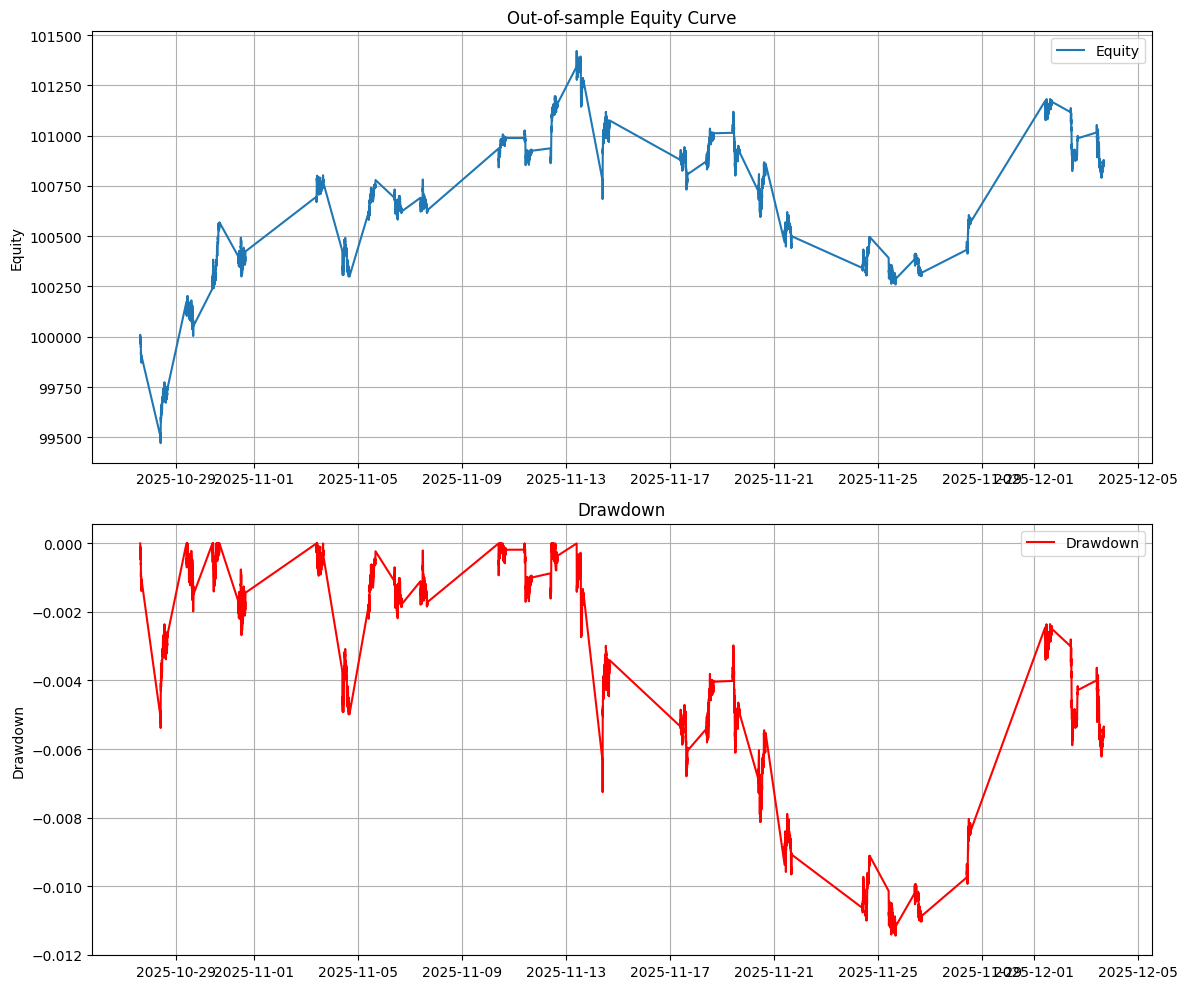


Saved account value to ppo_oos_account_value.csv
Saved stats to ppo_oos_stats.csv


In [12]:
df_account_value, stats = backtest_on_env(
    env_test,
    ppo_agent,
    idx_test,
    freq_per_year=252 * 390,
    plot=True,
    save_prefix="ppo_oos",
)


/var/folders/wb/f_2shphs10v29hfwgt77lpxw0000gn/T/ipykernel_58955/1984260504.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_weights_resampled = df_weights.resample('1H').mean().dropna()


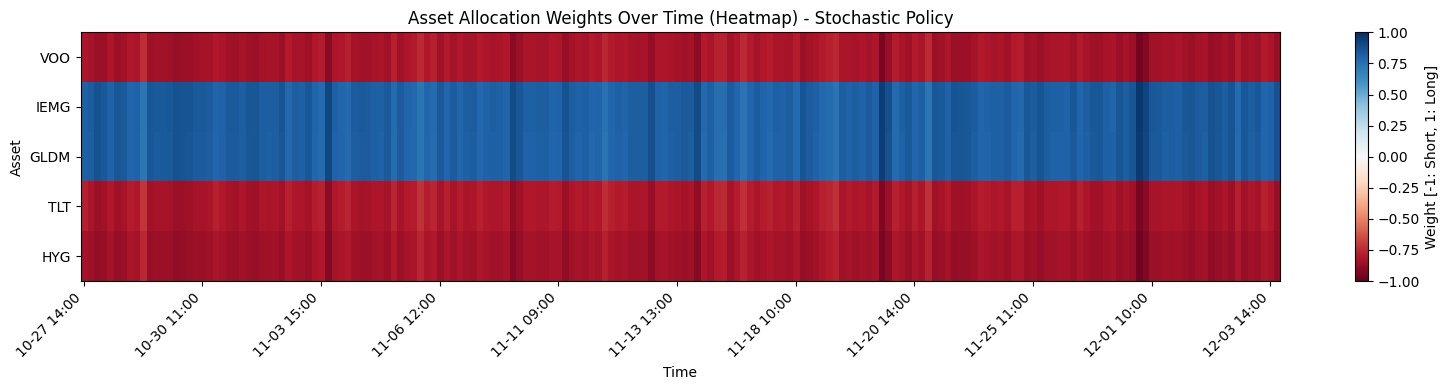


Weight Statistics:
               VOO         IEMG         GLDM          TLT          HYG
count  9939.000000  9939.000000  9939.000000  9939.000000  9939.000000
mean     -0.823446     0.821861     0.819213    -0.810116    -0.841734
std       0.093147     0.100355     0.099511     0.100200     0.090674
min      -0.999439     0.407437     0.410421    -0.999550    -0.999745
25%      -0.895015     0.760432     0.757580    -0.886553    -0.911036
50%      -0.836693     0.837576     0.834109    -0.824069    -0.856321
75%      -0.764796     0.898934     0.895245    -0.746321    -0.786158
max      -0.431701     0.999663     0.999649    -0.399756    -0.453297

Average absolute weight change per step: 0.071222


In [13]:
TICKERS = ("VOO", "IEMG", "GLDM", "TLT", "HYG")

obs, info = env_test.reset()
timestamps = []
weights_list = []
done = False

while not done:
    action, _, _ = ppo_agent.act_deterministic(obs)
    obs, reward, terminated, truncated, info = env_test.step(action)
    done = terminated or truncated
    t_idx = min(env_test.t, len(idx_test) - 1)
    timestamps.append(idx_test[t_idx])
    weights_list.append(info["weights"].copy())

df_weights = pd.DataFrame(weights_list, index=timestamps, columns=TICKERS)

df_weights_resampled = df_weights.resample('1H').mean().dropna()

fig, ax = plt.subplots(figsize=(16, 4))

heatmap_data = df_weights_resampled.T

im = ax.imshow(heatmap_data.values, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)

ax.set_yticks(range(len(TICKERS)))
ax.set_yticklabels(TICKERS)

n_labels = 10
step = max(1, len(df_weights_resampled) // n_labels)
x_positions = range(0, len(df_weights_resampled), step)
x_labels = [df_weights_resampled.index[i].strftime('%m-%d %H:%M') for i in x_positions]
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45, ha='right')

ax.set_xlabel('Time')
ax.set_ylabel('Asset')
ax.set_title('Asset Allocation Weights Over Time (Heatmap) - Stochastic Policy')

cbar = plt.colorbar(im, ax=ax, label='Weight [-1: Short, 1: Long]')

plt.tight_layout()
plt.show()

print("\nWeight Statistics:")
print(df_weights.describe())
print(f"\nAverage absolute weight change per step: {np.abs(df_weights.diff()).mean().mean():.6f}")


In [14]:
df_weights.describe()

,VOO,IEMG,GLDM,TLT,HYG
count,9939.000000,9939.000000,9939.000000,9939.000000,9939.000000
mean,-0.823446,0.821861,0.819213,-0.810116,-0.841734
std,0.093147,0.100355,0.099511,0.100200,0.090674
min,-0.999439,0.407437,0.410421,-0.999550,-0.999745
25%,-0.895015,0.760432,0.757580,-0.886553,-0.911036
50%,-0.836693,0.837576,0.834109,-0.824069,-0.856321
75%,-0.764796,0.898934,0.895245,-0.746321,-0.786158
max,-0.431701,0.999663,0.999649,-0.399756,-0.453297
